# CICDDoS2019

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from py.functions import (
    plot_confusion_matrix,
    criar_stream,
    carregar_e_unificar,
    visualizar_radares_separados_referencia,
    visualizar_assinaturas_barras
)

In [2]:
ARQUIVOS_ALVO = [
    'datasets\CICDDoS2019\data\CICDDoS2019_01_12_balanceado.csv',
    'datasets\CICDDoS2019\data\CICDDoS2019_03_11_balanceado.csv'
]

CHUNK_SIZE = 100000

df = carregar_e_unificar(ARQUIVOS_ALVO, CHUNK_SIZE)
df.value_counts("Label")

Iniciando processamento integral de 2 arquivos...
Dataset Unificado Pronto: 2000263 linhas.


Label
Syn              123215
Portmap          121524
MSSQL            121234
TFTP             120511
UDPLag           119680
DrDoS_NetBIOS    118710
DrDoS_MSSQL      117590
DrDoS_SSDP       117479
NetBIOS          117459
UDP              117152
DrDoS_DNS        116641
DrDoS_UDP        115985
LDAP             115946
DrDoS_LDAP       115536
DrDoS_NTP        114251
BENIGN           113828
DrDoS_SNMP       113522
Name: count, dtype: int64

In [8]:
# relatorio_grupos = analisar_grupos_similares(df_analise, top_features, limiar=0.98)
# display(relatorio_grupos)

# identificar_assinaturas_por_ataque(df_analise, 5, 10000, n_iteracoes=10)

## Processamento 

### Downsample 

In [6]:
def processar_e_salvar_dia(
        dia,
        dataset_path,
        chunk_size,
        cols_to_drop,
        attack_order,
        output_files,
        ATTACK_LABEL_COL,
        BENIGN_LABEL,
        DOWNSAMPLE_FACTORS,
        MIN_SAMPLES_PER_CHUNK
    ):
    
    lista_arquivos = attack_order[dia]
    output_filepath = output_files[dia]
    total_amostras_mantidas = 0
    header_escrito = False

    LABEL_COL_LIMPA = ATTACK_LABEL_COL.strip() 
    COLS_DROP_LIMPA = [c.strip() for c in cols_to_drop]

    with open(output_filepath, 'w', newline='', encoding='utf-8') as f:
        
        for filename in lista_arquivos:
            filepath = os.path.join(dataset_path, dia, filename)
            attack_name_from_file = filename.replace('.csv', '')
            
            try:
                csv_reader = pd.read_csv(
                    filepath, 
                    chunksize=chunk_size, 
                    low_memory=False, 
                    on_bad_lines='skip'
                )
            except Exception:
                continue
                
            for df_chunk in csv_reader:
                
                # Remove espaços das colunas do DATAFRAME (O que você já fez)
                df_chunk.columns = df_chunk.columns.str.strip()
                
                # Limpeza de Colunas (Usando a lista limpa)
                cols_existentes_drop = [col for col in COLS_DROP_LIMPA if col in df_chunk.columns]
                df_chunk = df_chunk.drop(columns=cols_existentes_drop, errors='ignore')
                
                # Normalização do Rótulo
                if LABEL_COL_LIMPA in df_chunk.columns:
                    df_chunk[LABEL_COL_LIMPA] = df_chunk[LABEL_COL_LIMPA].apply(
                        lambda x: BENIGN_LABEL if 'BENIGN' in str(x).upper() else attack_name_from_file
                    )
                else:
                    # Se não achar a coluna Label mesmo após limpar, pula
                    continue
                
                # Usa a variável limpa para filtrar
                df_benign = df_chunk[df_chunk[LABEL_COL_LIMPA] == BENIGN_LABEL]
                df_ataque = df_chunk[df_chunk[LABEL_COL_LIMPA] != BENIGN_LABEL]

                if not df_ataque.empty:
                    factor = DOWNSAMPLE_FACTORS.get(attack_name_from_file, DOWNSAMPLE_FACTORS['Default'])
                    
                    if len(df_ataque) < MIN_SAMPLES_PER_CHUNK:
                        factor = 1.0
                    
                    if factor < 1.0:
                        df_ataque = df_ataque.sample(frac=factor, random_state=42)

                # Combina e Restaura a Ordem pelo Índice
                df_chunk_reduzido = pd.concat([df_benign, df_ataque])
                df_chunk_reduzido = df_chunk_reduzido.sort_index()
                
                if df_chunk_reduzido.empty:
                    continue

                # Salvamento
                df_chunk_reduzido.to_csv(
                    f,
                    index=False,
                    header=not header_escrito,
                    mode='a'
                )
                header_escrito = True
                total_amostras_mantidas += len(df_chunk_reduzido)

    return total_amostras_mantidas

In [7]:
DATASET_PATH = 'datasets/CICDDoS2019/'
PANDAS_CHUNK_SIZE = 100000 
ATTACK_LABEL_COL = ' Label' 
COLUMNS_TO_DROP = ['Unnamed: 0', 'Flow ID', 'SimillarHTTP']
MIN_SAMPLES_PER_CHUNK = 1000
BENIGN_LABEL = 'BENIGN'

# Simula o REAL
# DOWNSAMPLE_FACTORS = {
#     'BENIGN': 1.0,           
#     'WebDDoS': 1.0,          
#     'TFTP': 0.0002,          
#     'DrDoS_DNS': 0.001,      
#     'DrDoS_LDAP': 0.001,
#     'DrDoS_MSSQL': 0.001,
#     'DrDoS_NTP': 0.001,
#     'DrDoS_NetBIOS': 0.001,
#     'DrDoS_SNMP': 0.001,
#     'DrDoS_SSDP': 0.001,
#     'DrDoS_UDP': 0.001,
#     'LDAP': 0.001,            
#     'MSSQL': 0.001,
#     'NetBIOS': 0.001,
#     'UDP': 0.001,
#     'Syn': 0.0015,            
#     'UDPLag': 0.005,           
#     'Portmap': 0.01,          
#     'Default': 0.001          
# }

# A Classe Ataques Majoritária
# DOWNSAMPLE_FACTORS = {
#     'WebDDoS': 1.0,          
#     'TFTP': 0.001,           
#     # Reflexão Massiva
#     'DrDoS_DNS': 0.01,       
#     'DrDoS_LDAP': 0.01,
#     'DrDoS_MSSQL': 0.01,
#     'DrDoS_NTP': 0.01,
#     'DrDoS_NetBIOS': 0.01,
#     'DrDoS_SNMP': 0.01,
#     'DrDoS_SSDP': 0.01,
#     'DrDoS_UDP': 0.01,
#     # FAMÍLIA EXPLORAÇÃO/REFLEXÃO 
#     'LDAP': 0.01,            
#     'MSSQL': 0.01,
#     'NetBIOS': 0.01,
#     'UDP': 0.01,
#     # FAMÍLIA TÁTICA 
#     'Syn': 0.05,             
#     'Portmap': 0.1,          
#     'UDPLag': 0.2,           
#     'Default': 0.01          
# }


# A concatenação dos 2 dias fica balanceado (Grande)
DOWNSAMPLE_FACTORS = {
    'WebDDoS': 1.0,          
    'Syn': 0.021,             
    'UDPLag': 0.11,           
    'TFTP': 0.006,           
    'DrDoS_SNMP': 0.022,      
    'DrDoS_DNS': 0.023,       
    'DrDoS_MSSQL': 0.026,     
    'DrDoS_NetBIOS': 0.029,   
    'DrDoS_UDP': 0.037,       
    'DrDoS_SSDP': 0.045,      
    'DrDoS_LDAP': 0.053,      
    'DrDoS_NTP': 0.095,       
    'MSSQL': 0.021,           
    'NetBIOS': 0.034,         
    'UDP': 0.031,             
    'LDAP': 0.055,            
    'Portmap': 0.65,          
    'Default': 0.02           
}

ATTACK_ORDER = {
    '03-11': [
        'Portmap.csv', 'NetBIOS.csv', 'LDAP.csv', 'MSSQL.csv', 'UDP.csv', 'UDPLag.csv', 'Syn.csv'
    ],
    '01-12': [
        'DrDoS_NTP.csv', 'DrDoS_DNS.csv', 'DrDoS_LDAP.csv', 'DrDoS_MSSQL.csv', 'DrDoS_NetBIOS.csv', 'DrDoS_SNMP.csv', 'DrDoS_SSDP.csv', 'DrDoS_UDP.csv', 
        'UDPLag.csv', 'Syn.csv', 'TFTP.csv' 
    ]
}

OUTPUT_FILES = {
    '03-11': 'CICDDoS2019_03_11.csv',
    '01-12': 'CICDDoS2019_01_12.csv'
}

dia_0311 = processar_e_salvar_dia(
    dia='03-11', 
    dataset_path=DATASET_PATH,
    chunk_size=PANDAS_CHUNK_SIZE,
    cols_to_drop=COLUMNS_TO_DROP,
    attack_order=ATTACK_ORDER,
    output_files=OUTPUT_FILES,
    ATTACK_LABEL_COL=ATTACK_LABEL_COL,
    BENIGN_LABEL=BENIGN_LABEL,
    DOWNSAMPLE_FACTORS=DOWNSAMPLE_FACTORS,
    MIN_SAMPLES_PER_CHUNK=MIN_SAMPLES_PER_CHUNK
)
print(f"Dataset salvo: {OUTPUT_FILES['03-11']} (Total: {dia_0311:,} amostras)")

dia_0112 = processar_e_salvar_dia(
    dia='01-12', 
    dataset_path=DATASET_PATH,
    chunk_size=PANDAS_CHUNK_SIZE,
    cols_to_drop=COLUMNS_TO_DROP,
    attack_order=ATTACK_ORDER,
    output_files=OUTPUT_FILES,
    ATTACK_LABEL_COL=ATTACK_LABEL_COL,
    BENIGN_LABEL=BENIGN_LABEL,
    DOWNSAMPLE_FACTORS=DOWNSAMPLE_FACTORS,
    MIN_SAMPLES_PER_CHUNK=MIN_SAMPLES_PER_CHUNK
)
print(f"Dataset salvo: {OUTPUT_FILES['01-12']} (Total: {dia_0112:,} amostras)")

Dataset salvo: CICDDoS2019_03_11.csv (Total: 819,585 amostras)
Dataset salvo: CICDDoS2019_01_12.csv (Total: 1,180,678 amostras)


### Verificação da Base de dados gerada

Label
TFTP             120511
DrDoS_NetBIOS    118710
DrDoS_MSSQL      117590
DrDoS_SSDP       117479
DrDoS_DNS        116641
DrDoS_UDP        115985
DrDoS_LDAP       115536
DrDoS_NTP        114251
DrDoS_SNMP       113522
BENIGN            56863
UDPLag            40359
Syn               33231
Name: count, dtype: int64


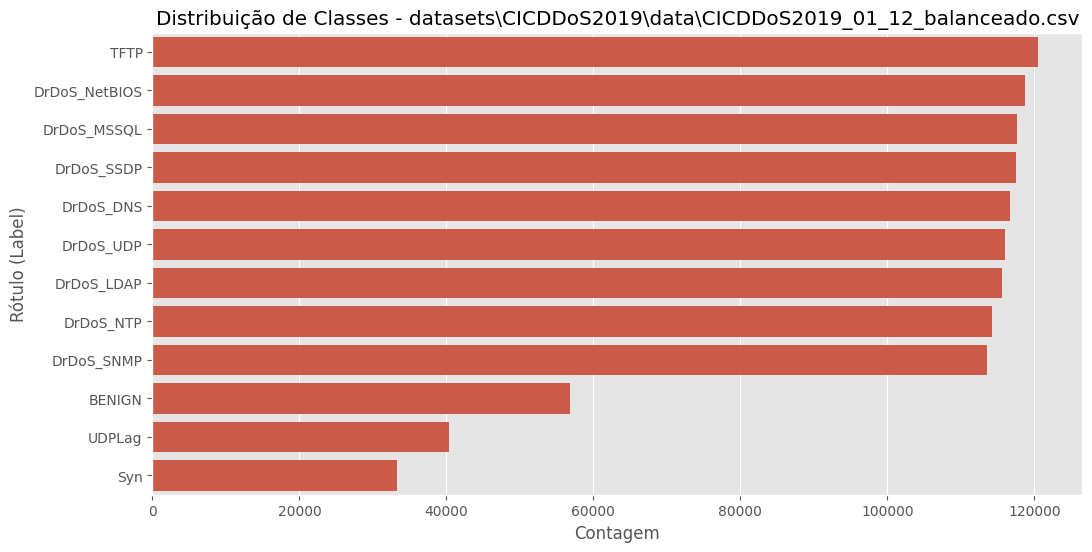

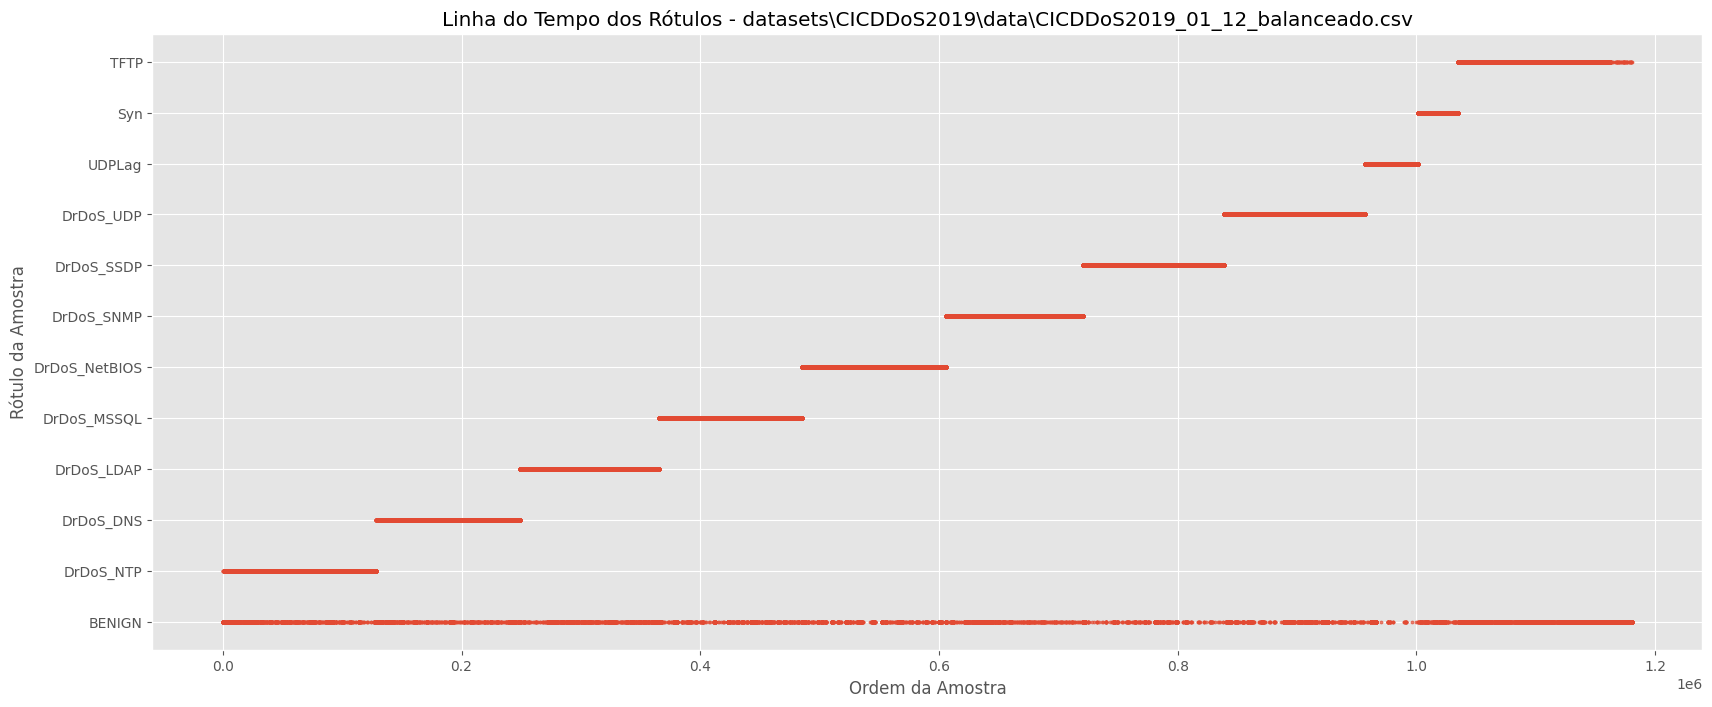

In [8]:
# --- Análise Exploratória do Dataset  ---
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7) 
plt.style.use('ggplot') 

# --- Carregar o Dataset de Teste ---
# file = 'datasets\CICDDoS2019\CICDDoS2019_03_11.csv'
file = 'datasets\CICDDoS2019\data\CICDDoS2019_01_12_balanceado.csv'
# file = 'CICDDoS2019_01_12.csv'

df = pd.read_csv(file)

# --- Contagem de Rótulos ---
print(df['Label'].value_counts())

# --- Gráfico de Contagem de Rótulos ---
plt.figure(figsize=(12, 6))
sns.countplot(y=df['Label'], order=df['Label'].value_counts().index)
plt.title(f'Distribuição de Classes - {file}')
plt.xlabel('Contagem')
plt.ylabel('Rótulo (Label)')
plt.show()

# Ordenar o DataFrame pelo Timestamp e plotar o gráfico da linha do tempo
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df_sorted = df.sort_values(by='Timestamp')

# Resetar o index para que o eixo X do gráfico seja a ordem da amostra
df_sorted = df_sorted.reset_index(drop=True)

# --- Gráfico da Ordem dos Rótulos ---
plt.figure(figsize=(20, 8))
plt.scatter(df_sorted.index, df_sorted['Label'], s=5, alpha=0.7)
plt.title(f'Linha do Tempo dos Rótulos - {file}')
plt.xlabel('Ordem da Amostra')
plt.ylabel('Rótulo da Amostra')
plt.show()

## Análise dos Ataques

![Ataques](datasets/CICDDoS2019/img/ataques.png)

### DEVELOP

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import QuantileTransformer, LabelEncoder
from scipy.spatial.distance import squareform

TAMANHO_AMOSTRA = 500000
MEU_THRESHOLD = 0.10
COLUNA_LABEL = 'Label' 

print("1. Preparação dos Dados")

# Amostragem Estratificada Segura
n_por_grupo = TAMANHO_AMOSTRA // len(df[COLUNA_LABEL].unique())

df_amostra = df.groupby(COLUNA_LABEL).apply(
    lambda x: x.sample(n=min(len(x), n_por_grupo), random_state=42),
    include_groups=False 
).reset_index(level=0)

X_raw = df_amostra.drop(columns=[COLUNA_LABEL])
y = df_amostra[COLUNA_LABEL]

# Limpeza e Normalização
X_numeric = X_raw.select_dtypes(include=[np.number]).copy()
X_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
X_numeric.fillna(X_numeric.median(), inplace=True)

scaler = QuantileTransformer(output_distribution='normal', random_state=42)
X_trans = scaler.fit_transform(X_numeric)
labels_unique = y.unique()

df_amostra.value_counts("Label")

1. Preparação dos Dados


NameError: name 'df' is not defined

In [ ]:
print("2. Seleção de Features e Extração de Assinaturas ")

#  Selecionar as Top 20 Features 
rf_sel = RandomForestClassifier(n_estimators=150, max_depth=20, n_jobs=-1, random_state=42)
le = LabelEncoder()
y_num = le.fit_transform(y)
rf_sel.fit(X_trans, y_num)

importancias = rf_sel.feature_importances_
indices_top = np.argsort(importancias)[-20:] # Pega índices das top 20
X_final = X_trans[:, indices_top]            # Filtra dataset
feature_names_final = X_numeric.columns[indices_top]

# Extrair Assinatura de Cada Ataque 
print("   > Extraindo DNA de cada tipo de ataque...")
final_signatures = []

for label in labels_unique:
    y_binary = (y == label).astype(int)
    rf = RandomForestClassifier(n_estimators=150, max_depth=20, max_features='sqrt', n_jobs=-1, random_state=42)
    rf.fit(X_final, y_binary)
    final_signatures.append(rf.feature_importances_)

df_final_sig = pd.DataFrame(final_signatures, index=labels_unique, columns=feature_names_final)

print("   > Matriz de Assinaturas Extraídas...")
display(df_final_sig)

2. Seleção de Features e Extração de Assinaturas 
   > Extraindo DNA de cada tipo de ataque...
   > Matriz de Assinaturas Extraídas...


,Init_Win_bytes_forward,Flow IAT Mean,act_data_pkt_fwd,Flow Packets/s,Total Fwd Packets,ACK Flag Count,Inbound,Flow Bytes/s,Destination Port,Total Length of Fwd Packets,Subflow Fwd Bytes,Max Packet Length,Packet Length Mean,Fwd Packet Length Min,Avg Fwd Segment Size,Fwd Packet Length Mean,Min Packet Length,Average Packet Size,Fwd Packet Length Max,Source Port
BENIGN,0.073735,0.007243,0.002577,0.005701,0.011366,0.102044,0.251433,0.003201,0.162317,0.014669,0.015744,0.023473,0.032672,0.050403,0.044856,0.031064,0.061387,0.035677,0.016563,0.053874
DrDoS_DNS,0.000968,0.058734,0.000830,0.049138,0.001388,0.000006,0.000698,0.076006,0.102132,0.021718,0.017230,0.034734,0.041086,0.073163,0.057105,0.042629,0.098228,0.087918,0.045370,0.190920
DrDoS_LDAP,0.000093,0.034981,0.000166,0.026414,0.000128,0.000007,0.000051,0.055194,0.112893,0.014245,0.006713,0.025903,0.043908,0.089179,0.076568,0.062307,0.121855,0.060438,0.046228,0.222731
DrDoS_MSSQL,0.000413,0.008455,0.013684,0.011770,0.015472,0.000002,0.000755,0.026761,0.014858,0.146086,0.119190,0.063922,0.050827,0.067646,0.061519,0.043382,0.061867,0.065385,0.056882,0.171125
DrDoS_NTP,0.001852,0.044204,0.151478,0.035337,0.100652,0.000060,0.002635,0.033361,0.002762,0.145257,0.151946,0.046501,0.031850,0.014650,0.022523,0.068357,0.019125,0.021005,0.049239,0.057206
DrDoS_NetBIOS,0.000463,0.003765,0.009014,0.002069,0.000864,0.001875,0.000068,0.010100,0.010678,0.054303,0.046005,0.078519,0.072610,0.135775,0.118943,0.114427,0.149345,0.072465,0.100140,0.018571
DrDoS_SNMP,0.000125,0.103107,0.000072,0.083222,0.001115,0.000004,0.000050,0.139516,0.062279,0.020021,0.016431,0.032997,0.038462,0.069889,0.063336,0.050968,0.094688,0.049285,0.046917,0.127515
DrDoS_SSDP,0.003140,0.022397,0.005113,0.020745,0.001694,0.001263,0.001413,0.018946,0.043231,0.032062,0.031649,0.063669,0.093098,0.120847,0.099214,0.106086,0.084387,0.056729,0.086403,0.107913
DrDoS_UDP,0.002842,0.020685,0.003446,0.021414,0.001038,0.001151,0.000861,0.025206,0.042975,0.021155,0.030041,0.070375,0.086828,0.110022,0.113071,0.108033,0.095104,0.052916,0.093227,0.099612
Syn,0.123351,0.048211,0.008582,0.050669,0.083209,0.196358,0.015471,0.003898,0.040457,0.039812,0.013344,0.083761,0.067028,0.003696,0.034917,0.025885,0.003843,0.069592,0.044084,0.043832


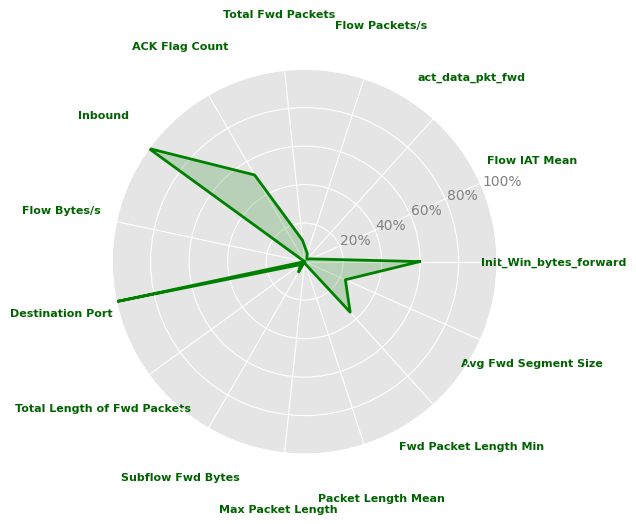

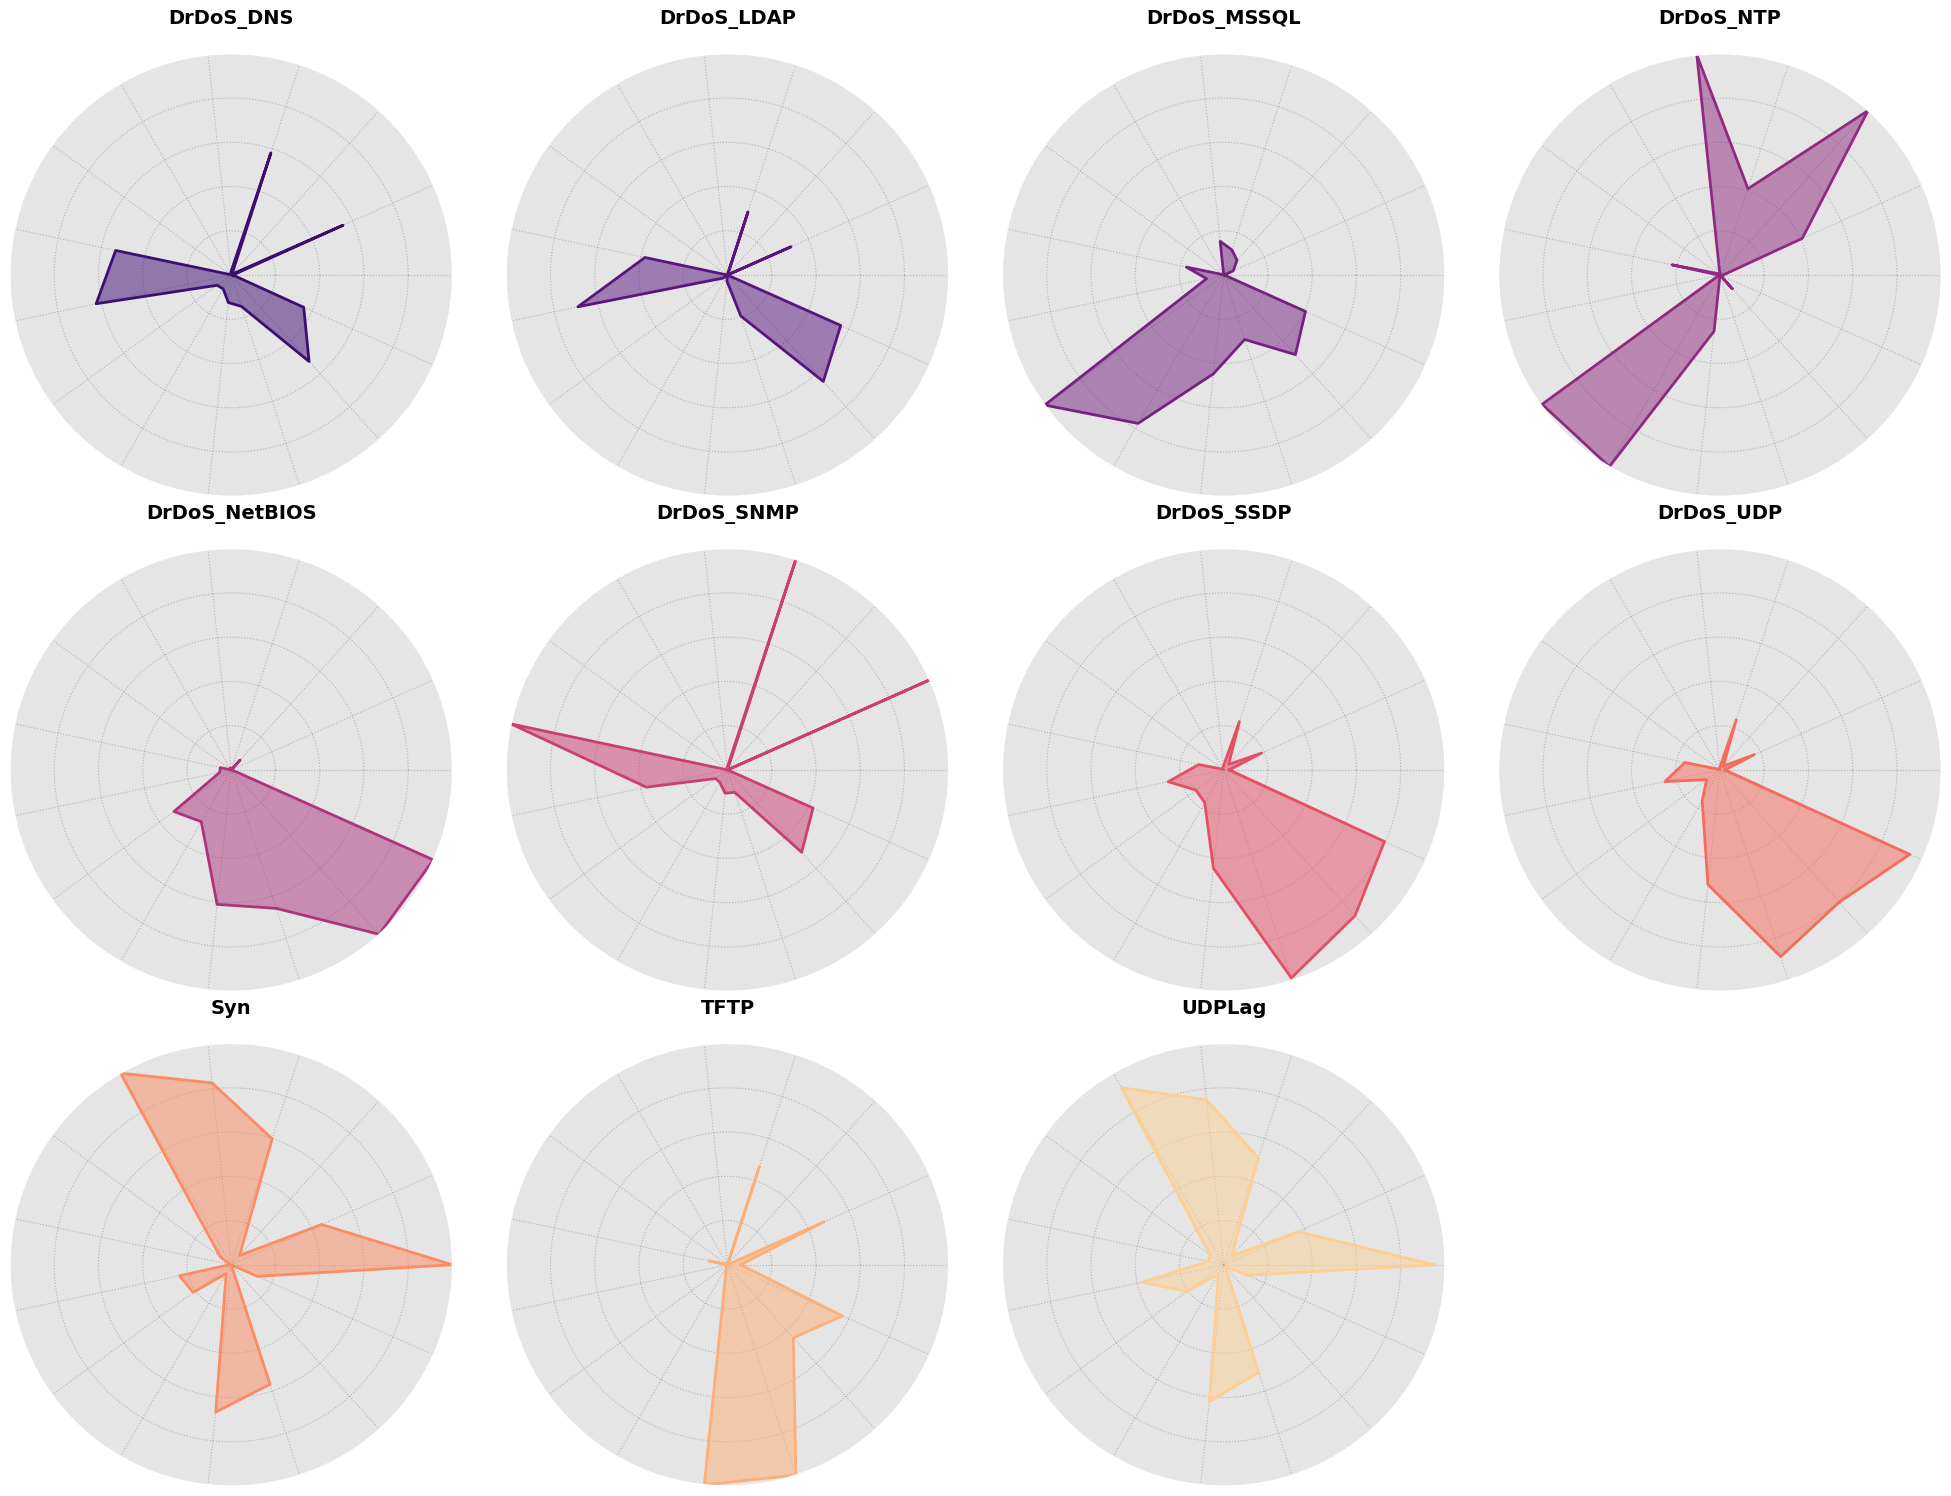

In [ ]:
features_para_plotar = df_final_sig.columns[:15].tolist() 

df_radar_ready = df_final_sig.copy()
df_radar_ready = df_radar_ready.reset_index() 
df_radar_ready = df_radar_ready.rename(columns={'index': 'Label'})

visualizar_radares_separados_referencia(df_radar_ready, features_para_plotar)

In [ ]:
print("3. Cálculo de Distância e Definição de Grupos")

# Matriz de Distância
final_sim = cosine_similarity(df_final_sig)
final_dist = 1 - final_sim
np.fill_diagonal(final_dist, 0)
final_dist = np.clip(final_dist, 0, 1)
dist_condensada = squareform(final_dist)

print(f"   > Aplicando corte com Threshold={MEU_THRESHOLD}...")
final_clustering = AgglomerativeClustering(
    n_clusters=None,              
    distance_threshold=MEU_THRESHOLD, 
    metric='precomputed', 
    linkage='complete'
)
final_labels = final_clustering.fit_predict(final_dist)

3. Cálculo de Distância e Definição de Grupos
   > Aplicando corte com Threshold=0.1...


,Grupo ID,Ataques,Similaridade Interna,Assinatura
0,0,"DrDoS_SSDP, DrDoS_UDP, TFTP",0.9541,"Fwd Packet Length Mean, Source Port, Fwd Packe..."
1,1,"DrDoS_DNS, DrDoS_LDAP",0.9772,"Source Port, Min Packet Length, Destination Port"
2,2,DrDoS_NetBIOS,1.0000,"Min Packet Length, Fwd Packet Length Min, Avg ..."
3,3,DrDoS_SNMP,1.0000,"Flow Bytes/s, Source Port, Flow IAT Mean"
4,4,"Syn, UDPLag",0.9909,"ACK Flag Count, Init_Win_bytes_forward, Max Pa..."
5,5,DrDoS_MSSQL,1.0000,"Source Port, Total Length of Fwd Packets, Subf..."
6,6,DrDoS_NTP,1.0000,"Subflow Fwd Bytes, act_data_pkt_fwd, Total Len..."
7,7,BENIGN,1.0000,"Inbound, Destination Port, ACK Flag Count"


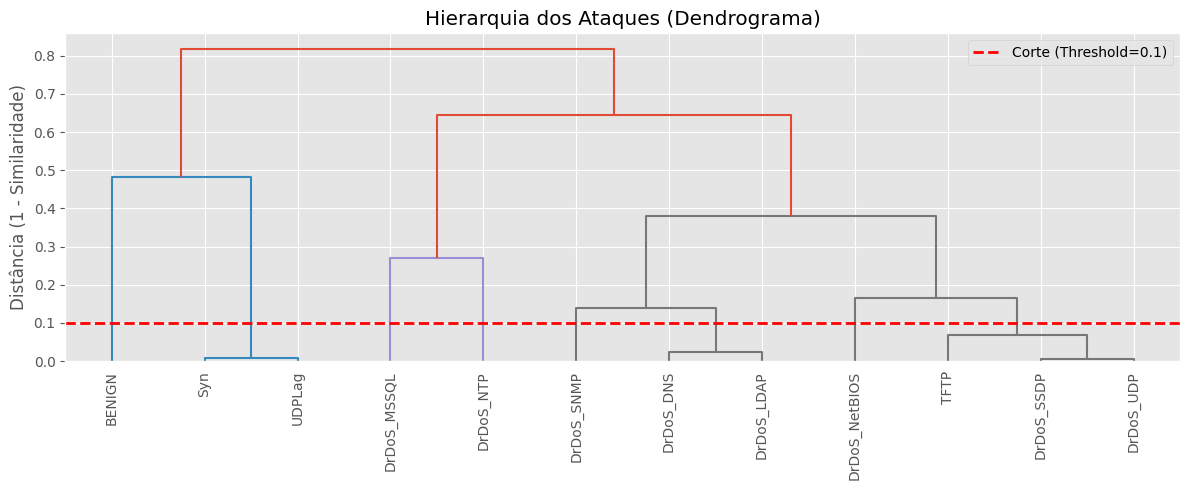

In [ ]:
report = []

for cid in sorted(set(final_labels)):
    membros = df_final_sig.index[final_labels == cid].tolist()
    
    # Média de similaridade interna
    if len(membros) > 1:
        sub_sim = pd.DataFrame(final_sim, index=labels_unique, columns=labels_unique).loc[membros, membros]
        mask = np.ones(sub_sim.shape, dtype=bool)
        np.fill_diagonal(mask, 0)
        avg_sim = sub_sim.values[mask].mean()
    else:
        avg_sim = 1.000
        
    # Principais características do grupo
    avg_imp = df_final_sig.loc[membros].mean()
    top_feats = avg_imp.nlargest(3).index.tolist()
    
    report.append({
        'Grupo ID': cid,
        'Ataques': ", ".join(membros),
        'Similaridade Interna': f"{avg_sim:.4f}",
        'Assinatura': ", ".join(top_feats)
    })

display(pd.DataFrame(report))

#  VISUALIZAÇÃO DENDROGRAMA
plt.figure(figsize=(12, 5))
Z = linkage(dist_condensada, method='complete')
dendrogram(Z, labels=labels_unique, leaf_rotation=90., leaf_font_size=10.)
plt.axhline(y=MEU_THRESHOLD, c='r', ls='--', lw=2, label=f'Corte (Threshold={MEU_THRESHOLD})')
plt.title("Hierarquia dos Ataques (Dendrograma)")
plt.ylabel("Distância (1 - Similaridade)")
plt.legend()
plt.tight_layout()
plt.show()


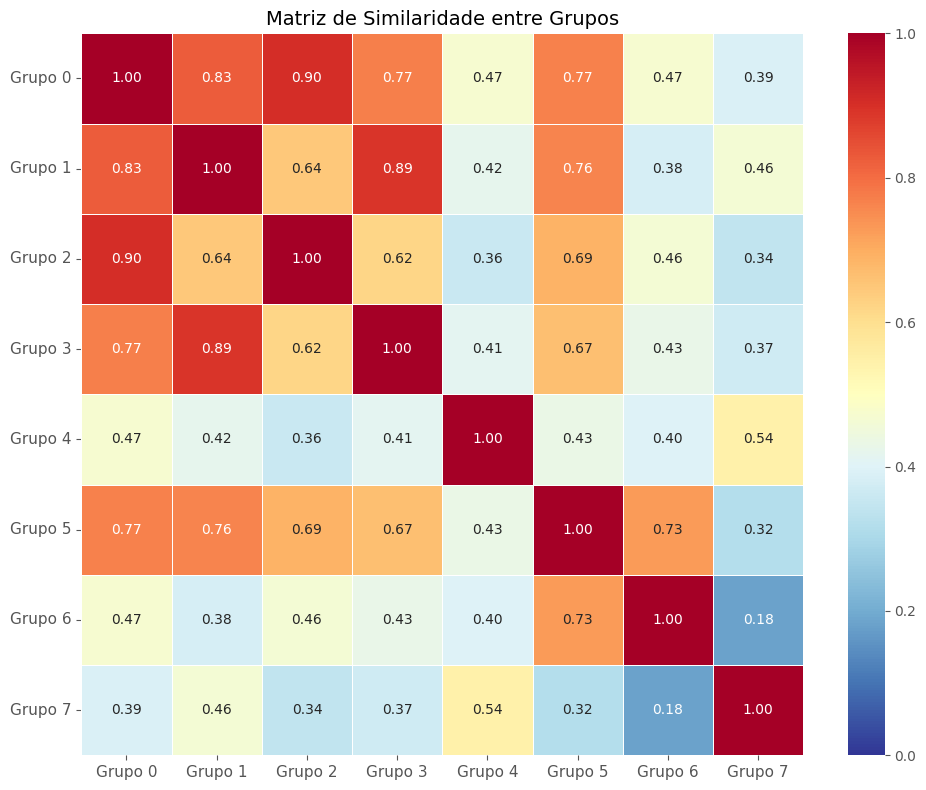

In [ ]:
# Recuperando dados brutos da memória
unique_clusters = sorted(list(set(final_labels)))
cluster_vectors = []
cluster_names = []

for cid in unique_clusters:
    # Encontra índices dos ataques neste cluster
    indices = [i for i, label in enumerate(final_labels) if label == cid]
    
    # Calcula o vetor médio (Centróide)
    mean_vector = df_final_sig.iloc[indices].mean().values
    cluster_vectors.append(mean_vector)
    cluster_names.append(f"Grupo {cid}")

# Calcula similaridade
cluster_sim_matrix = cosine_similarity(cluster_vectors)
df_cluster_sim = pd.DataFrame(cluster_sim_matrix, index=cluster_names, columns=cluster_names)

# 1. Plotar Heatmap (Matriz Limpa)
plt.figure(figsize=(10, 8))
sns.heatmap(
    df_cluster_sim, 
    annot=True, 
    fmt=".2f", 
    cmap='RdYlBu_r', 
    vmin=0, 
    vmax=1,
    square=True,
    linewidths=.5
)
plt.title("Matriz de Similaridade entre Grupos", fontsize=14)
plt.xticks(rotation=0, fontsize=11) 
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()

## Base de dados para verificar se os modelos identificam a semelhança entre os ataques durante o treinamento

In [3]:
import pandas as pd
import numpy as np
import os

def gerar_cenario_dinamico(df, sequencia_labels, pct_sujeira, tamanho_bloco_ataque, nome_cenario, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    
    df = df.drop(columns=['Origem_Arquivo', 'Unnamed: 0'], errors='ignore')
    
    df_benign_pool = df[df['Label'] == 'BENIGN'].sample(frac=1, random_state=42)
    total_benign_disponivel = len(df_benign_pool)
    
    qtd_ataques = len([x for x in sequencia_labels if x != 'BENIGN'])
    qtd_intervalos_benign = len([x for x in sequencia_labels if x == 'BENIGN'])
    
    qtd_ruido_por_ataque = int(tamanho_bloco_ataque * pct_sujeira)
    qtd_ataque_puro = int(tamanho_bloco_ataque * (1 - pct_sujeira))
    
    total_ruido_necessario = qtd_ruido_por_ataque * qtd_ataques
    
    if total_ruido_necessario > total_benign_disponivel:
        raise ValueError(f"Erro: Não há dados benignos suficientes para o ruído solicitado. Necessário: {total_ruido_necessario}, Disponível: {total_benign_disponivel}")
    
    df_noise_pool = df_benign_pool.iloc[:total_ruido_necessario]
    df_benign_intervals_pool = df_benign_pool.iloc[total_ruido_necessario:]
    
    tamanho_intervalo_benign = 0
    if qtd_intervalos_benign > 0:
        tamanho_intervalo_benign = int(len(df_benign_intervals_pool) / qtd_intervalos_benign)
    
    df_list = []
    metadata = []
    indice_global = 0
    
    idx_noise = 0
    idx_interval = 0
    
    for label in sequencia_labels:
        if label == 'BENIGN':
            start = idx_interval * tamanho_intervalo_benign
            end = start + tamanho_intervalo_benign
            
            chunk = df_benign_intervals_pool.iloc[start:end]
            df_list.append(chunk)
            
            metadata.append({
                'Evento': f"BENIGN_Intervalo_{idx_interval+1}",
                'Inicio': indice_global,
                'Fim': indice_global + len(chunk),
                'Tipo': 'Normal'
            })
            
            indice_global += len(chunk)
            idx_interval += 1
            
        else:
            start_noise = idx_noise * qtd_ruido_por_ataque
            end_noise = start_noise + qtd_ruido_por_ataque
            noise_chunk = df_noise_pool.iloc[start_noise:end_noise]
            
            try:
                attack_raw = df[df['Label'] == label].sample(n=qtd_ataque_puro, random_state=42 + idx_noise)
            except ValueError:
                print(f"Aviso: Dados insuficientes para o ataque {label}. Usando o que tem disponível.")
                attack_raw = df[df['Label'] == label]
            
            attack_block = pd.concat([attack_raw, noise_chunk]).sample(frac=1, random_state=42)
            df_list.append(attack_block)
            
            metadata.append({
                'Evento': f"ATAQUE_{label}",
                'Inicio': indice_global,
                'Fim': indice_global + len(attack_block),
                'Tipo': 'Ataque'
            })
            
            indice_global += len(attack_block)
            idx_noise += 1
            
    df_final = pd.concat(df_list, ignore_index=True)
    
    csv_name = f"stream_{nome_cenario}.csv"
    meta_name = f"metadata_{nome_cenario}.csv"
    
    df_final.to_csv(os.path.join(output_dir, csv_name), index=False)
    pd.DataFrame(metadata).to_csv(os.path.join(output_dir, meta_name), index=False)
    
    print(f"Cenário '{nome_cenario}' gerado com sucesso em: {output_dir}")
    print(f"Estrutura: {len(df_final)} linhas | {pct_sujeira*100}% de sujeira nos ataques.")
    
    return df_final, metadata

In [19]:
DIRETORIO_BASE = r"datasets\CICDDoS2019\Experimentos"
TAMANHO_BLOCO = 30000
SUJEIRA = 0.40

sequencia_c1 = [
    'BENIGN', 
    'DrDoS_LDAP', 
    'BENIGN', 
    'DrDoS_NetBIOS', 
    'BENIGN', 
    'Syn', 
    'BENIGN'
]

df_c1, meta_c1 = gerar_cenario_dinamico(
    df=df,
    sequencia_labels=sequencia_c1,
    pct_sujeira=SUJEIRA,
    tamanho_bloco_ataque=TAMANHO_BLOCO,
    nome_cenario="Imunidade",
    output_dir=os.path.join(DIRETORIO_BASE, "Exp_1")
)

sequencia_c2 = [
    'BENIGN', 
    'DrDoS_UDP', 
    'BENIGN', 
    'DrDoS_MSSQL', 
    'BENIGN', 
    'DrDoS_UDP', 
    'BENIGN'
]

df_c2, meta_c2 = gerar_cenario_dinamico(
    df=df,
    sequencia_labels=sequencia_c2,
    pct_sujeira=SUJEIRA,
    tamanho_bloco_ataque=TAMANHO_BLOCO,
    nome_cenario="Memoria",
    output_dir=os.path.join(DIRETORIO_BASE, "Exp_2")
)

sequencia_c3 = [
    'BENIGN', 
    'UDP', 
    'BENIGN', 
    'DrDoS_NTP', 
    'BENIGN', 
    'DrDoS_DNS', 
    'BENIGN'
]

df_c3, meta_c3 = gerar_cenario_dinamico(
    df=df,
    sequencia_labels=sequencia_c3,
    pct_sujeira=SUJEIRA,
    tamanho_bloco_ataque=TAMANHO_BLOCO,
    nome_cenario="Complexidade",
    output_dir=os.path.join(DIRETORIO_BASE, "Exp_3")
)



Cenário 'Imunidade' gerado com sucesso em: datasets\CICDDoS2019\Experimentos\Exp_1
Estrutura: 110860 linhas | 40.0% de sujeira nos ataques.
Cenário 'Memoria' gerado com sucesso em: datasets\CICDDoS2019\Experimentos\Exp_2
Estrutura: 110860 linhas | 40.0% de sujeira nos ataques.
Aviso: Dados insuficientes para o ataque UDP. Usando o que tem disponível.
Cenário 'Complexidade' gerado com sucesso em: datasets\CICDDoS2019\Experimentos\Exp_3
Estrutura: 92860 linhas | 40.0% de sujeira nos ataques.


In [9]:
DIRETORIO_BASE = r"datasets\CICDDoS2019\Experimentos"
TAMANHO_BLOCO = 30000
SUJEIRA = 0.40

# As sequencias A e B são fluxos do cenário heterogêneo
# As sequencias acabam com o primeiro ataque para testar a memória.
sequencia_cA = [
    'BENIGN',
    'Syn',
    'BENIGN',
    'DrDoS_NTP',
    'BENIGN',
    'Syn',
    'BENIGN'
]

df_cA, meta_cA = gerar_cenario_dinamico(
    df=df,
    sequencia_labels=sequencia_cA,
    pct_sujeira=SUJEIRA,
    tamanho_bloco_ataque=TAMANHO_BLOCO,
    nome_cenario="Heterogeneidade_A",
    output_dir=os.path.join(DIRETORIO_BASE, "Exp_A")
)

sequencia_cB = [
    'BENIGN',
    'DrDoS_NTP',
    'BENIGN',
    'Syn',
    'BENIGN',
    'DrDoS_NTP',
    'BENIGN'
]

df_cB, meta_cB = gerar_cenario_dinamico(
    df=df,
    sequencia_labels=sequencia_cB,
    pct_sujeira=SUJEIRA,
    tamanho_bloco_ataque=TAMANHO_BLOCO,
    nome_cenario="Heterogeneidade_B",
    output_dir=os.path.join(DIRETORIO_BASE, "Exp_B")
)

Cenário 'Heterogeneidade_A' gerado com sucesso em: datasets\CICDDoS2019\Experimentos\Exp_A
Estrutura: 110860 linhas | 40.0% de sujeira nos ataques.
Cenário 'Heterogeneidade_B' gerado com sucesso em: datasets\CICDDoS2019\Experimentos\Exp_B
Estrutura: 110860 linhas | 40.0% de sujeira nos ataques.


In [6]:
DIRETORIO_BASE = r"datasets\CICDDoS2019\Experimentos"
TAMANHO_BLOCO = 30000
SUJEIRA = 0.40

# DrDoS_SSDP (A) e DrDoS_UDP (B) são os ataques muito semelhantes, aqui é formado um cenário que trabalha a homogenidade.
# A -> B -> A
sequencia_cD = [
    'BENIGN',
    'DrDoS_SSDP',
    'BENIGN',
    'DrDoS_UDP',
    'BENIGN',
    'DrDoS_SSDP',
    'BENIGN'
]

df_cD, meta_cD = gerar_cenario_dinamico(
    df=df,
    sequencia_labels=sequencia_cD,
    pct_sujeira=SUJEIRA,
    tamanho_bloco_ataque=TAMANHO_BLOCO,
    nome_cenario="homogeneidade_D",
    output_dir=os.path.join(DIRETORIO_BASE, "Exp_D")
)

# A -> A -> B
sequencia_cE = [
    'BENIGN',
    'DrDoS_SSDP',
    'BENIGN',
    'DrDoS_SSDP',
    'BENIGN',
    'DrDoS_UDP',
    'BENIGN',
]

df_cE, meta_cE = gerar_cenario_dinamico(
    df=df,
    sequencia_labels=sequencia_cE,
    pct_sujeira=SUJEIRA,
    tamanho_bloco_ataque=TAMANHO_BLOCO,
    nome_cenario="homogeneidade_E",
    output_dir=os.path.join(DIRETORIO_BASE, "Exp_E")
)


Cenário 'homogeneidade_D' gerado com sucesso em: datasets\CICDDoS2019\Experimentos\Exp_D
Estrutura: 167828 linhas | 40.0% de sujeira nos ataques.
Cenário 'homogeneidade_E' gerado com sucesso em: datasets\CICDDoS2019\Experimentos\Exp_E
Estrutura: 167828 linhas | 40.0% de sujeira nos ataques.


In [5]:
DIRETORIO_BASE = r"datasets\CICDDoS2019\Experimentos"
TAMANHO_BLOCO = 30000
SUJEIRA = 0.40

# DrDoS_SSDP (A) e DrDoS_UDP (B) são os ataques muito semelhantes, aqui é formado um cenário que trabalha a homogenidade.
# B -> A -> B
sequencia_cF = [
    'BENIGN',
    'DrDoS_UDP',
    'BENIGN',
    'DrDoS_SSDP',
    'BENIGN',
    'DrDoS_UDP',
    'BENIGN'
]

df_cF, meta_cF = gerar_cenario_dinamico(
    df=df,
    sequencia_labels=sequencia_cF,
    pct_sujeira=SUJEIRA,
    tamanho_bloco_ataque=TAMANHO_BLOCO,
    nome_cenario="homogeneidade_F",
    output_dir=os.path.join(DIRETORIO_BASE, "Exp_F")
)

# DrDoS_SSDP (A), DrDoS_UDP (B), TFTP (C)  são os ataques muito semelhantes, aqui é formado um cenário que trabalha a homogenidade.
# A -> B -> C -> A
sequencia_cG = [
    'BENIGN',
    'DrDoS_SSDP',
    'BENIGN',
    'DrDoS_UDP',
    'BENIGN',
    'TFTP',
    'BENIGN',
    'DrDoS_SSDP',
    'BENIGN'
]

df_cG, meta_cG = gerar_cenario_dinamico(
    df=df,
    sequencia_labels=sequencia_cG,
    pct_sujeira=SUJEIRA,
    tamanho_bloco_ataque=TAMANHO_BLOCO,
    nome_cenario="homogeneidade_G",
    output_dir=os.path.join(DIRETORIO_BASE, "Exp_G")
)

# DrDoS_SSDP (A), DrDoS_UDP (B), TFTP (C)  são os ataques muito semelhantes, aqui é formado um cenário que trabalha a homogenidade.
# C -> B -> A -> C
sequencia_cH = [
    'BENIGN',
    'TFTP',
    'BENIGN',
    'DrDoS_UDP',
    'BENIGN',
    'DrDoS_SSDP',
    'BENIGN',
    'TFTP',
    'BENIGN'
]

df_cH, meta_cH = gerar_cenario_dinamico(
    df=df,
    sequencia_labels=sequencia_cH,
    pct_sujeira=SUJEIRA,
    tamanho_bloco_ataque=TAMANHO_BLOCO,
    nome_cenario="homogeneidade_H",
    output_dir=os.path.join(DIRETORIO_BASE, "Exp_H")
)



Cenário 'homogeneidade_F' gerado com sucesso em: datasets\CICDDoS2019\Experimentos\Exp_F
Estrutura: 167828 linhas | 40.0% de sujeira nos ataques.
Cenário 'homogeneidade_G' gerado com sucesso em: datasets\CICDDoS2019\Experimentos\Exp_G
Estrutura: 185825 linhas | 40.0% de sujeira nos ataques.
Cenário 'homogeneidade_H' gerado com sucesso em: datasets\CICDDoS2019\Experimentos\Exp_H
Estrutura: 185825 linhas | 40.0% de sujeira nos ataques.


In [4]:
DIRETORIO_BASE = r"datasets\CICDDoS2019\Experimentos"
TAMANHO_BLOCO = 30000
SUJEIRA = 0.40

# Os três ataques são muito diferentes entre si, aqui é formado um cenário que trabalha a homogenidade e teste de memória.
# X -> Y -> Z -> X
sequencia_cI = [
    'BENIGN',
    'DrDoS_DNS',
    'BENIGN',
    'DrDoS_NetBIOS',
    'BENIGN',
    'Syn',
    'BENIGN',
    'DrDoS_DNS',
    'BENIGN'
]

df_cI, meta_cI = gerar_cenario_dinamico(
    df=df,
    sequencia_labels=sequencia_cI,
    pct_sujeira=SUJEIRA,
    tamanho_bloco_ataque=TAMANHO_BLOCO,
    nome_cenario="heterogeneidade_I",
    output_dir=os.path.join(DIRETORIO_BASE, "Exp_I")
)

Cenário 'heterogeneidade_I' gerado com sucesso em: datasets\CICDDoS2019\Experimentos\Exp_I
Estrutura: 185825 linhas | 40.0% de sujeira nos ataques.


In [6]:
DIRETORIO_BASE = r"datasets\CICDDoS2019\Experimentos"
TAMANHO_BLOCO = 15000
SUJEIRA = 0.40

# Aqui coloquei um ataque de cada grupo, para testar a adaptação a varias mudanças de conceito seguida, e também a memória, já que o último ataque é o mesmo do primeiro.
sequencia_cJ = [
    'BENIGN',
    'DrDoS_SSDP',
    'BENIGN',
    'DrDoS_DNS',
    'BENIGN',
    'DrDoS_NetBIOS',
    'BENIGN',
    'DrDoS_SNMP',
    'BENIGN',
    'Syn',
    'BENIGN',
    'DrDoS_MSSQL',
    'BENIGN',
    'DrDoS_NTP',
    'BENIGN',
    'DrDoS_SSDP'
]

df_cJ, meta_cJ = gerar_cenario_dinamico(
    df=df,
    sequencia_labels=sequencia_cJ,
    pct_sujeira=SUJEIRA,
    tamanho_bloco_ataque=TAMANHO_BLOCO,
    nome_cenario="heterogeneidade_J",
    output_dir=os.path.join(DIRETORIO_BASE, "Exp_J")
)

Cenário 'heterogeneidade_J' gerado com sucesso em: datasets\CICDDoS2019\Experimentos\Exp_J
Estrutura: 185824 linhas | 40.0% de sujeira nos ataques.
